In [1]:
# !pip install pyunpack
# !pip install patool

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# from pyunpack import Archive
# Archive('/content/drive/My Drive/Data_Set_2(Black_and_white_images).rar').extractall('/content/drive/My Drive/Data_Set_2(Black_and_white_images)')

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.decomposition import PCA

In [5]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.filename = filename
        self.data = pd.read_csv(folder + '/' + filename, header=None)
        self.y = torch.tensor(label_dict[self.filename.rstrip('.csv')], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data.iloc[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [6]:
def train_test_loader(directory, train_fraction=0.8, num_workers=2, batch_size=32):

    files = list(filter(lambda x: x.endswith('.csv') and x[0].isupper(), os.listdir(directory)))
    label_dict = {}

    i = 0
    for file in files:
        label_dict[file.rstrip('.csv')] = i
        i += 1

    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [7]:
trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_2(Black_and_white_images)', train_fraction=0.8, num_workers=0, batch_size=32)

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [9]:
X_train = []
for X, y in trainloader:
  X_train.extend(X.numpy())
X_train = np.array(X_train)

97% Variance Explained: 277


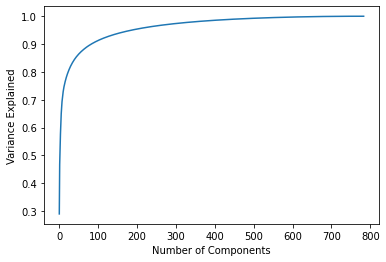

In [10]:
pca1 = PCA(n_components=X_train.shape[1])
pca1.fit(X_train)

print('97% Variance Explained:', np.where(np.cumsum(pca1.explained_variance_ratio_)>=0.97)[0][0]+1)
explained_var = np.cumsum(pca1.explained_variance_ratio_)
plt.plot(explained_var)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

In [11]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
ae1 = AutoEncoder(784, [400, 250, 400])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.0001, momentum=0.9)

Epoch 1 : Loss = 8185.370823242196
Epoch 2 : Loss = 5752.890410156243
Epoch 3 : Loss = 5650.850861328135
Epoch 4 : Loss = 5646.488164062503
Epoch 5 : Loss = 5646.377771484367
Epoch 6 : Loss = 5646.370902343757
Converged
Finished Training


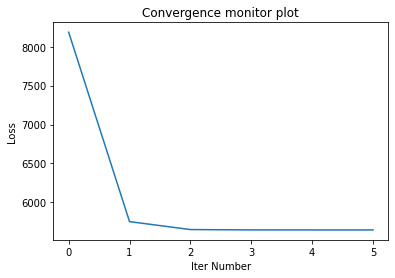

In [13]:
old_loss = np.inf

max_epoch = 100
losses = []

for epoch in range(max_epoch):

    running_loss = 0.0
    len_ = 0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    if (abs(running_loss-old_loss)/running_loss < 1e-5):
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [14]:
X_data_test = []
X_data_test_pred = []

test_loss = 0.0
len_ = 0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      X_pred = ae1(X)
      loss = criterion(X_pred, X)

    test_loss += loss.item()*len(X)

test_loss = test_loss/test_size
print(test_loss)

5656.327259114583


In [15]:
Z1_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)

    if len(Z1_array) == 0:
        Z1_array = Z1.cpu().numpy()
    else:
        Z1_array = np.append(Z1_array, Z1.cpu().numpy(), axis=0)

99% Variance Explained: 27


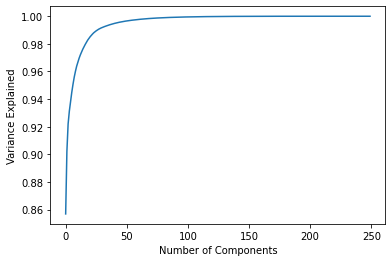

In [16]:
pca2 = PCA(n_components=Z1_array.shape[1])
pca2.fit(Z1_array)

print('99% Variance Explained:', np.where(np.cumsum(pca2.explained_variance_ratio_)>=0.99)[0][0]+1)
explained_var = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(explained_var)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

In [17]:
ae2 = AutoEncoder(250, [100, 50, 100])
optimizer2 = optim.SGD(ae2.parameters(), lr=0.001, momentum=0.8)
ae2 = ae2.to(device)

Epoch 1 : Loss = 1.4165661211796128
Epoch 2 : Loss = 0.04162734993547204
Epoch 3 : Loss = 0.04161952713628612
Epoch 4 : Loss = 0.041615944795310535
Epoch 5 : Loss = 0.041611725927641036
Epoch 6 : Loss = 0.04160560610642043
Epoch 7 : Loss = 0.041599138241261276
Epoch 8 : Loss = 0.04159370707099635
Epoch 9 : Loss = 0.041585481206576
Epoch 10 : Loss = 0.041570986258486785
Epoch 11 : Loss = 0.041560261941204546
Epoch 12 : Loss = 0.04154237802078328
Epoch 13 : Loss = 0.04151664589842159
Epoch 14 : Loss = 0.04147442718222736
Epoch 15 : Loss = 0.04140025055905189
Epoch 16 : Loss = 0.04127428408960496
Epoch 17 : Loss = 0.04094006556769208
Epoch 18 : Loss = 0.039621372895936105
Epoch 19 : Loss = 0.03420888602857788
Epoch 20 : Loss = 0.021834715999662867
Epoch 21 : Loss = 0.013558468683622765
Epoch 22 : Loss = 0.012114011302900799
Epoch 23 : Loss = 0.011714318135442828
Epoch 24 : Loss = 0.011451311991239596
Epoch 25 : Loss = 0.011238208106718975
Epoch 26 : Loss = 0.011062592968344704
Epoch 27 : 

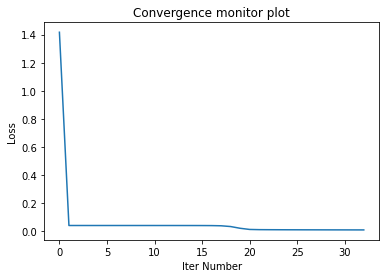

In [18]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer2.zero_grad()
        
        # Reconstructed Representation of X (forward)
        Z_hat = ae2(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer2.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    # print(abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 1e-2 and running_loss<0.015:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [19]:
X_data_test = []
X_data_test_pred = []

test_loss = 0.0
len_ = 0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
        
        Z1 = ae1.get_z(X)
        Z_pred = ae2(Z1)
        loss = criterion(Z_pred, Z1)

    test_loss += loss.item()*len(X)

test_loss = test_loss/test_size
print(test_loss)

0.00996525656680266


In [20]:
Z2_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)
      Z2 = ae2.get_z(Z1)

    if len(Z2_array) == 0:
        Z2_array = Z2.cpu().numpy()
    else:
        Z2_array = np.append(Z2_array, Z2.cpu().numpy(), axis=0)

99% Variance Explained: 6


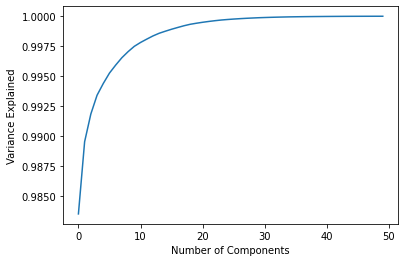

In [34]:
pca3 = PCA(n_components=Z2_array.shape[1])
pca3.fit(Z2_array)

print('99.5% Variance Explained:', np.where(np.cumsum(pca3.explained_variance_ratio_)>=0.995)[0][0]+1)
explained_var = np.cumsum(pca3.explained_variance_ratio_)
plt.plot(explained_var)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

In [22]:
ae3 = AutoEncoder(50, [25, 10, 25])
optimizer3 = optim.SGD(ae3.parameters(), lr=0.001, momentum=0.9)
ae3 = ae3.to(device)

Epoch 1 : Loss = 0.16552040971970802
inf
Epoch 2 : Loss = 0.014092816919088405
10.745019513842852
Epoch 3 : Loss = 0.010891782394610335
0.2938944617606447
Epoch 4 : Loss = 0.007266120175365353
0.49898186814157347
Epoch 5 : Loss = 0.005039545860296737
0.44182042921969006
Epoch 6 : Loss = 0.00423239970292586
0.19070650553464882
Epoch 7 : Loss = 0.003896790367395921
0.08612455479718664
Epoch 8 : Loss = 0.003648476377207155
0.06805964038578922
Epoch 9 : Loss = 0.0034243982738504804
0.06543575993125228
Epoch 10 : Loss = 0.0032137242439979037
0.0655544825434357
Epoch 11 : Loss = 0.003012786938498415
0.06669482761354392
Epoch 12 : Loss = 0.002818906539042175
0.06877858374194913
Epoch 13 : Loss = 0.0026313789169459235
0.07126591342986933
Epoch 14 : Loss = 0.002450305313570423
0.07389838416162597
Epoch 15 : Loss = 0.0022749837564770142
0.07706497094507062
Epoch 16 : Loss = 0.0021067472419235875
0.07985605069539176
Epoch 17 : Loss = 0.0019461947014788154
0.08249562097912211
Epoch 18 : Loss = 0.0

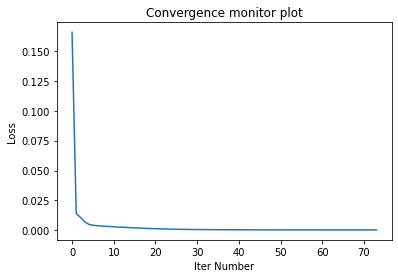

In [23]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z1 = ae1.get_z(X)
            Z = ae2.get_z(Z1)
        
        optimizer3.zero_grad()
        
        # Reconstructed Representation of Z (forward)
        Z_hat = ae3(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer3.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)
    if abs(running_loss-old_loss)/running_loss < 0.005 and running_loss<0.0005:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [24]:
X_data_test = []
X_data_test_pred = []

test_loss = 0.0
len_ = 0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
        
        Z1 = ae1.get_z(X)
        Z2 = ae2.get_z(Z1)
        Z_pred = ae3(Z2)
        loss = criterion(Z_pred, Z2)

    test_loss += loss.item()*len(X)

test_loss = test_loss/test_size
print(test_loss)

0.00035832016449421645


In [25]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(784, [400, 100, 25, 10], 10)

In [26]:
ae1_params = list(ae1.parameters())
ae2_params = list(ae2.parameters())
ae3_params = list(ae3.parameters())

with torch.no_grad():
    
    classifier.fc1.weight.data = nn.Parameter(ae1_params[0])
    classifier.fc1.bias.data = nn.Parameter(ae1_params[1])
    
    classifier.fc2.weight = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[2]))
    classifier.fc2.bias = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[3]) + ae2_params[1])
    
    classifier.fc3.weight = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[2]))
    classifier.fc3.bias = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[3]) + ae3_params[1])
    
    classifier.fc4.weight = nn.Parameter(ae3_params[2])
    classifier.fc4.bias = nn.Parameter(ae3_params[3])

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.0001, momentum=0.9)
classifier = classifier.to(device)

Epoch 1 : Loss = 2.299259348551432
inf
Epoch 2 : Loss = 2.1203877660433434
0.08435795818698949
Epoch 3 : Loss = 1.907895936091741
0.1113749581053591
Epoch 4 : Loss = 1.7732617911497732
0.07592457335623955
Epoch 5 : Loss = 1.6906769243876165
0.048847219460376755
Epoch 6 : Loss = 1.6205206958452856
0.043292398993853336
Epoch 7 : Loss = 1.5575947236220038
0.04039945132643671
Epoch 8 : Loss = 1.497676010688148
0.040007793745941475
Epoch 9 : Loss = 1.4432441889444987
0.037714907955705944
Epoch 10 : Loss = 1.3949180382887496
0.03464443740008867
Epoch 11 : Loss = 1.3584042579332978
0.026879907172114283
Epoch 12 : Loss = 1.3223789519468945
0.027242800509917706
Epoch 13 : Loss = 1.287375782489778
0.027189550971217207
Epoch 14 : Loss = 1.2565839847723634
0.024504369059735128
Epoch 15 : Loss = 1.2292393911679589
0.022245132885322812
Epoch 16 : Loss = 1.2031553900241867
0.02167966113109282
Epoch 17 : Loss = 1.1826382759809486
0.017348596320561332
Epoch 18 : Loss = 1.163548979520796
0.0164060961731

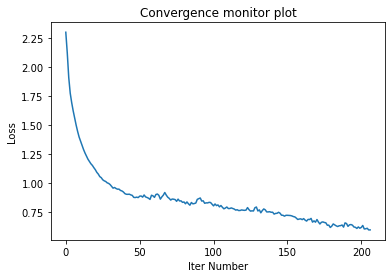

In [28]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 0.001 and running_loss<0.65:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [30]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())

acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.5915135145187378
Train Accuracy = 0.7688333333333334 Train Precision = 0.7557246790731876 Train F1 = 0.75236906336807


,0,1,2,3,4,5,6,7,8,9
0,3401,39,0,2,38,5,0,1195,128,0
1,29,4584,23,2,14,9,14,28,61,10
2,1,1,4455,0,0,0,46,0,1,275
3,95,7,0,4500,163,7,0,34,10,0
4,675,31,0,27,3612,234,0,32,199,0
5,70,94,3,6,379,3895,1,82,329,0
6,0,21,219,0,4,0,4043,0,0,467
7,830,95,2,1,18,31,2,3560,225,0
8,540,159,0,4,249,1017,0,2443,411,0
9,0,5,259,0,0,0,106,0,0,4443


In [31]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 0.6144968867301941


,0,1,2,3,4,5,6,7,8,9
0,845,7,0,2,7,2,0,297,32,0
1,9,1180,3,0,1,4,3,12,11,3
2,0,1,1123,0,0,0,11,0,0,86
3,28,2,0,1091,47,1,0,12,3,0
4,184,6,0,20,849,67,0,11,53,0
5,13,25,2,1,81,935,0,17,67,0
6,0,8,62,0,0,0,1063,0,0,113
7,244,22,0,0,8,11,0,889,62,0
8,137,40,1,1,53,239,0,606,100,0
9,0,0,71,0,0,0,36,0,0,1080


In [32]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.7629166666666667 Test Precision = 0.7499928585116448 Test F1 = 0.745333729361524
